## Imports

In [2]:
# installs catboost and seaborn
!pip install catboost
!pip install seaborn

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/huggingface_hub-0.29.2-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/huggingface_hub-0.29.2-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [123]:
#standard imports
import pandas as pd
import numpy as np
from collections import defaultdict

#processing
import shap
from sklearn.feature_extraction.text import TfidfVectorizer

#models
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

# scores
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import metrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read Dataset

In [126]:
# only using "train" dataset, as it will let us be able to compare our models' results with the table
dataset = pd.read_csv('data/train.csv')

print("Training Dataset:")
print(dataset.head())

print("\nNumber of Data Points:")
print(len(dataset))

Training Dataset:
   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More

## Preprocessing Data

In [129]:
#Preprocessing Data
# Define Categorical Columns
cat_cols = ["Gender", "City", "Working Professional or Student", 
            "Profession", "Sleep Duration", "Dietary Habits", "Degree",
            "Have you ever had suicidal thoughts ?", "Family History of Mental Illness"
]

# Define Numerical Columns
num_cols = ["Age", "Academic Pressure", "Work Pressure", "CGPA", 
            "Study Satisfaction", "Job Satisfaction",
            "Work/Study Hours", "Financial Stress"]

# Setting Empty Numerical Columns to 0
dataset[num_cols] = dataset[num_cols].fillna(0)

# set so there's no NaN values
dataset[cat_cols] = dataset[cat_cols].fillna("None").astype(str)

# Define Features
features = dataset.columns.tolist()
features.remove('id')
features.remove('Name')
features.remove('Depression')

# Define Label
label = dataset['Depression']

# define X and y
X = dataset[features]
y = dataset['Depression']

# One Hot Encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
y_encoded = pd.get_dummies(y, columns=['Depression'], drop_first=True).values.ravel()

dataset.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,0.0,5.0,0.00,0.0,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,0.0,4.0,0.00,0.0,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,None,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,0.0,5.0,0.00,0.0,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,0.0,1.0,0.00,0.0,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


## Logistic Regression

In [142]:
#Splitting on Encoded Data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=2)

# Intialize Logistic Regression with max_iter at 1000
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Training and Testing
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

#### Logistic Regression Accuracy

In [143]:
# Compare the "predicted labels" with its "actual labels" to evaluate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")

Logistic Regression Accuracy: 0.9383795309168443


#### Logistic Regression Confusion Matrix

Confusion matrix:
[[22206   762]
 [  972  4200]]


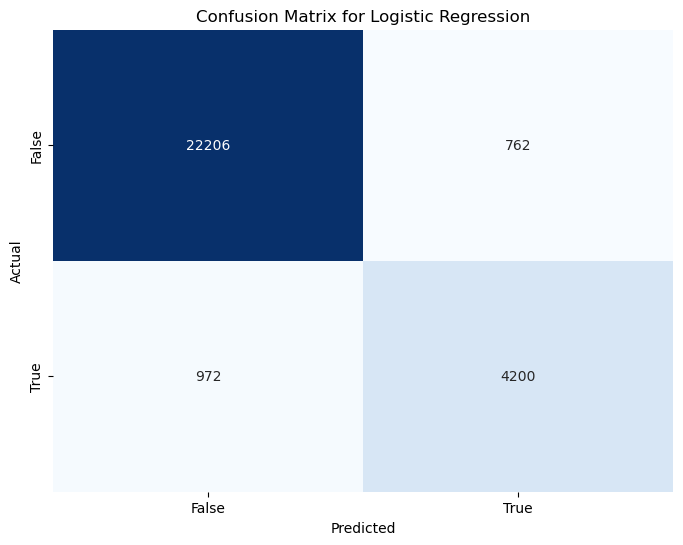

In [144]:
lr_cm = metrics.confusion_matrix(y_test, y_pred)

print("Confusion matrix:")

plt.figure(figsize=(8,6))
print(lr_cm)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["False", "True"], yticklabels=["False", "True"], cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print()

#### Logistic Regression ROC

Logistic Regression AUC: 0.9746822001652388


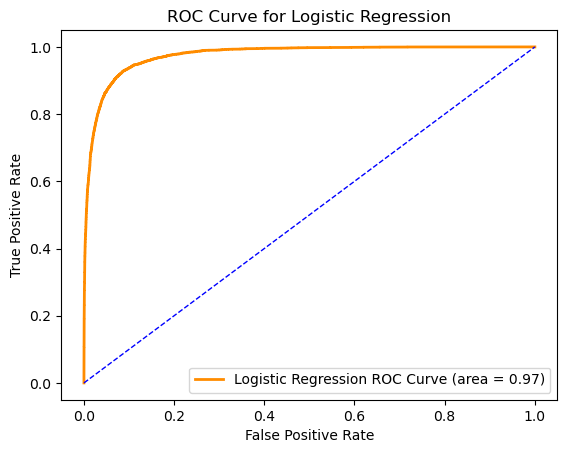

In [145]:
y_predict_prob = logreg.predict_proba(X_test)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:, 1], pos_label=1)
lr_AUC = metrics.auc(lr_fpr, lr_tpr)
print("Logistic Regression AUC:", lr_AUC)


plt.plot(lr_fpr, lr_tpr, color='darkorange', lw=2,
         label='Logistic Regression ROC Curve (area = %0.2f)' % lr_AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

#Labeling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")

#### Logistic Regression Feature Importance 

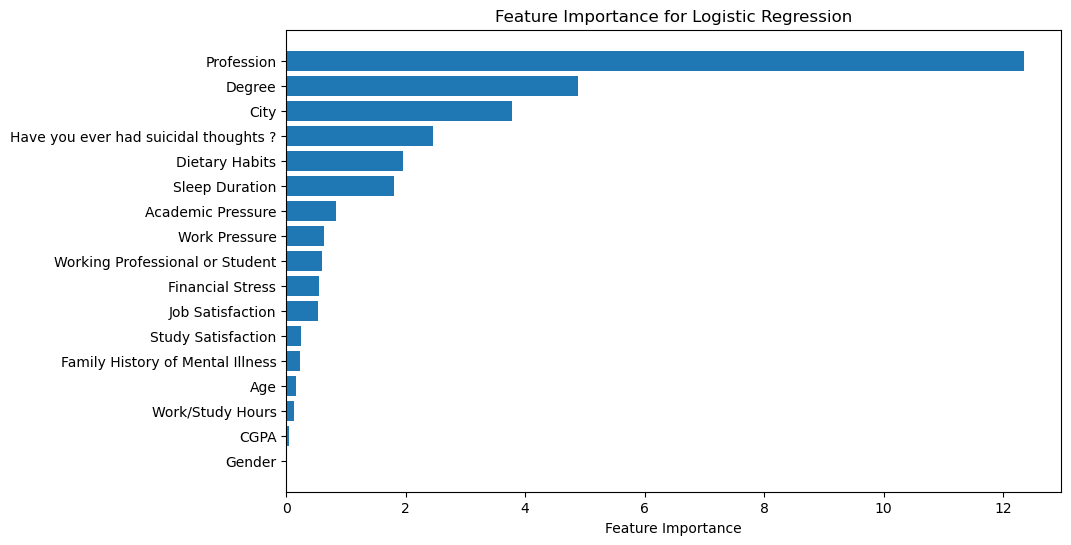

In [154]:
coefficients = logreg.coef_[0]
odds_ratios = np.exp(coefficients)

# importances = coefficients
# use absolute value for "normal" feature importance graph
importances = abs(coefficients)
feature_names = X_train.columns

# Combine into a DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Group by prefix (before underscore)
grouped_importance = defaultdict(float)

for feature, importance in zip(feat_df['Feature'], feat_df['Importance']):
    group_key = feature.split('_')[0]  # Use full name if no underscore
    grouped_importance[group_key] += importance

# Convert to sorted DataFrame
grouped_df = pd.DataFrame(grouped_importance.items(), columns=['Feature', 'Importance'])
grouped_df = grouped_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df['Feature'], grouped_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

## Random Forest

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=2)

#Initialize Random Forest Model
rf = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state=2)

# Training and Testing
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#### Random Forest Accuracy

In [21]:
# Compare the "predicted labels" with its "actual labels" to evaluate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy}")

Random Forest Classifier Accuracy: 0.9321250888415068


#### Random Forest Confusion Matrix

Random Forest AUC: 0.966667005077578
Confusion matrix:
[[22238   730]
 [ 1180  3992]]


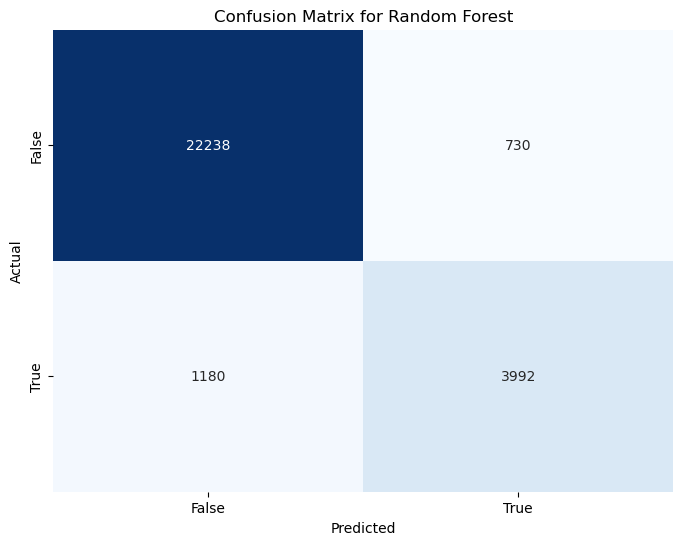

In [23]:
y_predict_prob = rf.predict_proba(X_test)
rf_fpr, rf_tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:, 1], pos_label=1)
rf_AUC = metrics.auc(rf_fpr, rf_tpr)
print("Random Forest AUC:", rf_AUC)

#Random Forest Confusion
cm_rf = metrics.confusion_matrix(y_test, y_pred)

print("Confusion matrix:")

plt.figure(figsize=(8,6))
print(cm_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=["False", "True"], yticklabels=["False", "True"], cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()
print()

#### Random Forest ROC

Random Forest AUC: 0.966667005077578


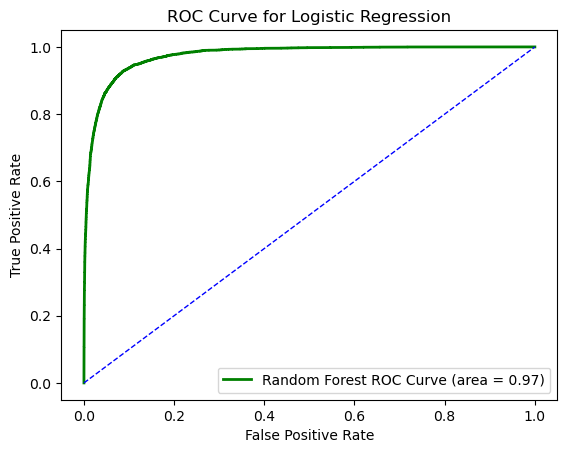

In [25]:
y_predict_prob = rf.predict_proba(X_test)
rf_fpr, rf_tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:, 1], pos_label=1)
rf_AUC = metrics.auc(rf_fpr, rf_tpr)
print("Random Forest AUC:", rf_AUC)


plt.plot(lr_fpr, lr_tpr, color='green', lw=2,
         label='Random Forest ROC Curve (area = %0.2f)' % lr_AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

#Labeling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")

#### Random Forest Feature Importance

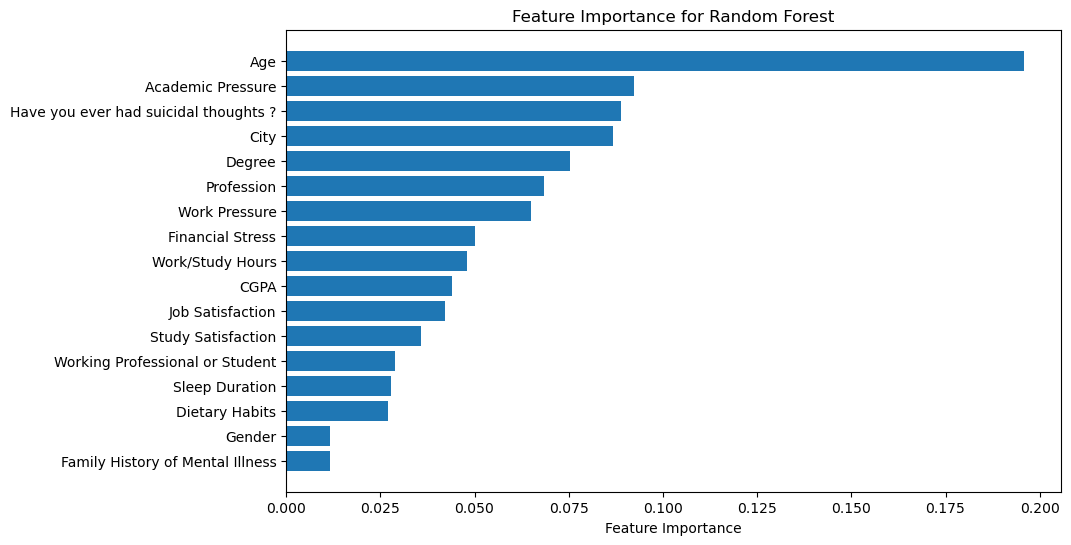

In [27]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Combine into a DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Group by prefix (before underscore)
grouped_importance = defaultdict(float)

for feature, importance in zip(feat_df['Feature'], feat_df['Importance']):
    group_key = feature.split('_')[0]  # Use full name if no underscore
    grouped_importance[group_key] += importance

# Convert to sorted DataFrame
grouped_df = pd.DataFrame(grouped_importance.items(), columns=['Feature', 'Importance'])
grouped_df = grouped_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df['Feature'], grouped_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()

## ANN

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded,
                                                    test_size=0.2,
                                                    random_state=2)

#Initialize ANN multi layer perceptron model
ann = MLPClassifier(hidden_layer_sizes=(5,5), activation= 'logistic',
                       solver='adam', alpha=1e-5, random_state=1,
                       learning_rate_init = 0.1, verbose=True, tol=0.0001)

# Training and Testing
ann.fit(X_train, y_train)
y_pred = ann.predict(X_test)

Iteration 1, loss = 0.18910556
Iteration 2, loss = 0.17258615
Iteration 3, loss = 0.17232743
Iteration 4, loss = 0.17169845
Iteration 5, loss = 0.17189749
Iteration 6, loss = 0.17268059
Iteration 7, loss = 0.17076836
Iteration 8, loss = 0.16890897
Iteration 9, loss = 0.17250530
Iteration 10, loss = 0.17180474
Iteration 11, loss = 0.17507766
Iteration 12, loss = 0.17445809
Iteration 13, loss = 0.17363844
Iteration 14, loss = 0.17447306
Iteration 15, loss = 0.17259897
Iteration 16, loss = 0.17267777
Iteration 17, loss = 0.17356931
Iteration 18, loss = 0.17276849
Iteration 19, loss = 0.16934812
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


#### ANN Accuracy

In [59]:
# Compare the "predicted labels" with its "actual labels" to evaluate accuracy
score_ann = accuracy_score(y_test, y_pred)
print('\n','accuracy: ',score_ann)


 accuracy:  0.9346481876332623


#### ANN Confusion Matrix

AUC ANN:  0.9725513899697834
ANN Confusion matrix:
[[22065   903]
 [  936  4236]]


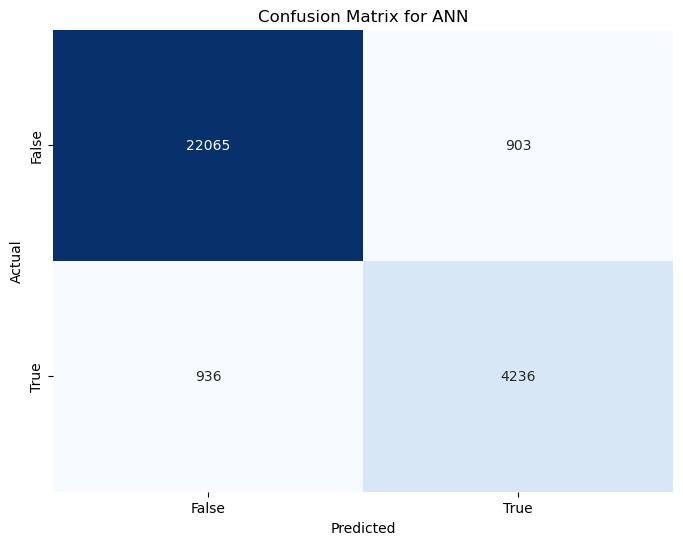

In [61]:
# ANN AUC
y_predict_prob = ann.predict_proba(X_test)
ann_fpr, ann_tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1], pos_label=1)
ann_AUC = metrics.auc(ann_fpr, ann_tpr)
print(f"AUC ANN:  {ann_AUC}")


#ANN Confusion
cm_ann = metrics.confusion_matrix(y_test, y_pred)
print("ANN Confusion matrix:")
plt.figure(figsize=(8,6))
print(cm_ann)
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', xticklabels=["False", "True"], yticklabels=["False", "True"], cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ANN')
plt.show()

#### ANN ROC Curve

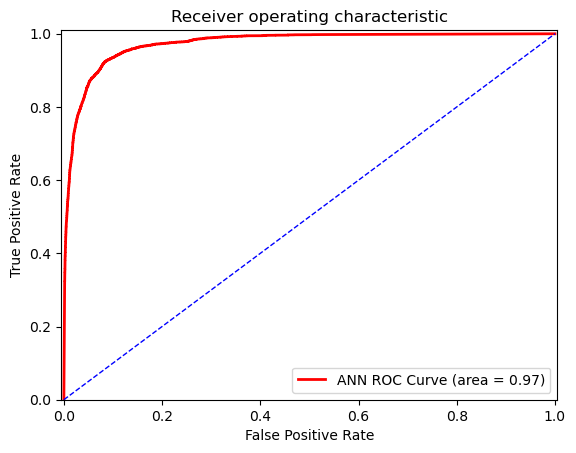

In [63]:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(ann_fpr, ann_tpr, color='red', lw=2,
         label='ANN ROC Curve (area = %0.2f)' % ann_AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

#### ANN Feature Importance 

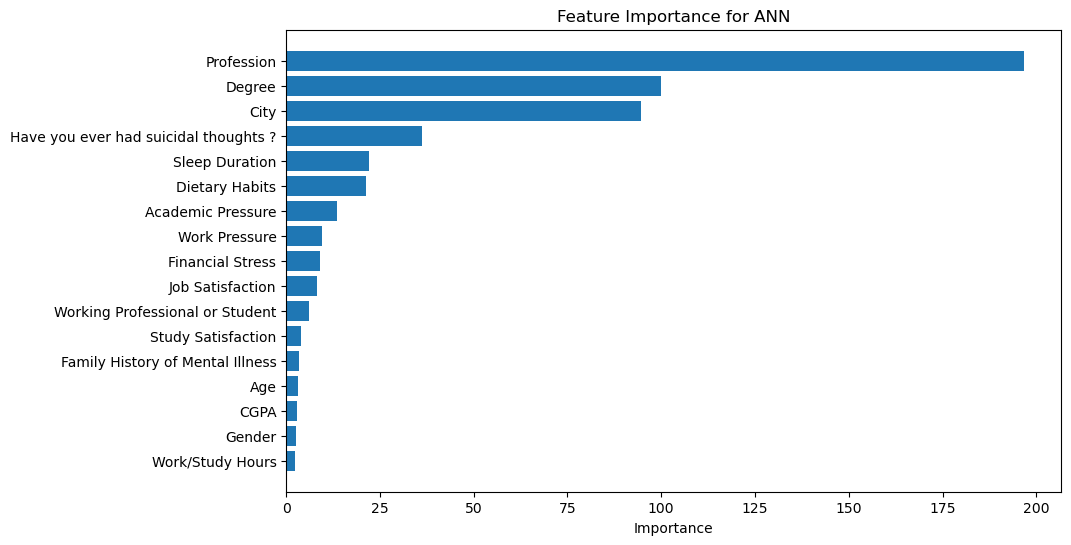

In [112]:
importances = np.mean(np.abs(ann.coefs_[0]), axis=1)
# importances = np.mean(ann.coefs_[0], axis=1)
feature_names = X_train.columns

# Combine into a DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Group by prefix (before underscore)
grouped_importance = defaultdict(float)

for feature, importance in zip(feat_df['Feature'], feat_df['Importance']):
    group_key = feature.split('_')[0]  # Use full name if no underscore
    grouped_importance[group_key] += importance

# Convert to sorted DataFrame
grouped_df = pd.DataFrame(grouped_importance.items(), columns=['Feature', 'Importance'])
grouped_df = grouped_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df['Feature'], grouped_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for ANN')
plt.gca().invert_yaxis()
plt.show()

## Catboost

In [158]:
# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
# Pooling Data
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

# Create Catboost Model
catboost = CatBoostClassifier(verbose=0)

#Training and Testing
catboost.fit(train_pool)
y_pred = catboost.predict(X_test)

#### Catboost Accuracy

In [133]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.938272921108742


#### Catboost Confusion Matrix

AUC Catboost:  0.976762111715113

[[22197   789]
 [  948  4206]]


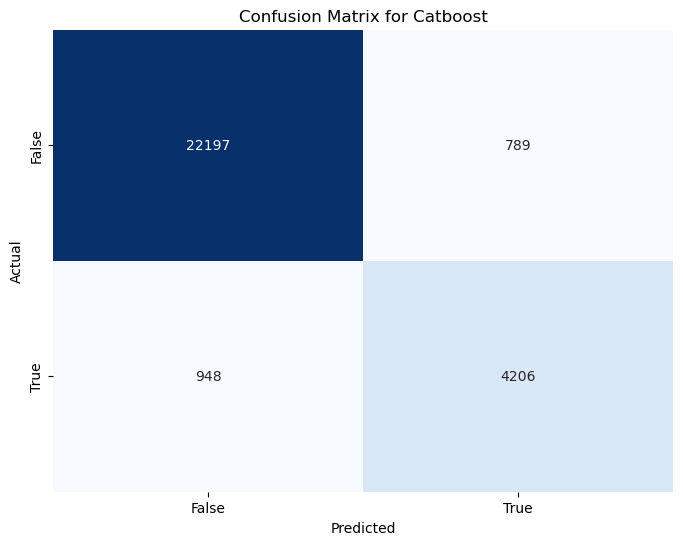

In [94]:
y_predict_prob = catboost.predict_proba(X_test)
cb_fpr, cb_tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:,1], pos_label=1)
cb_AUC = metrics.auc(cb_fpr, cb_tpr)
print(f"AUC Catboost:  {cb_AUC}\n")

#Catboost Confusion
cb_cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
print(cb_cm)
sns.heatmap(cb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["False", "True"], yticklabels=["False", "True"], cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Catboost')
plt.show()
print()

#### Catboost Feature Importance

Age: 31.93
Have you ever had suicidal thoughts ?: 16.58
Work Pressure: 8.49
Job Satisfaction: 8.09
Financial Stress: 7.67
Academic Pressure: 5.98
Work/Study Hours: 5.23
Dietary Habits: 3.55
Profession: 3.07
City: 2.26
Sleep Duration: 2.21
Degree: 2.03
CGPA: 1.08
Study Satisfaction: 0.93
Family History of Mental Illness: 0.48
Gender: 0.31
Working Professional or Student: 0.10


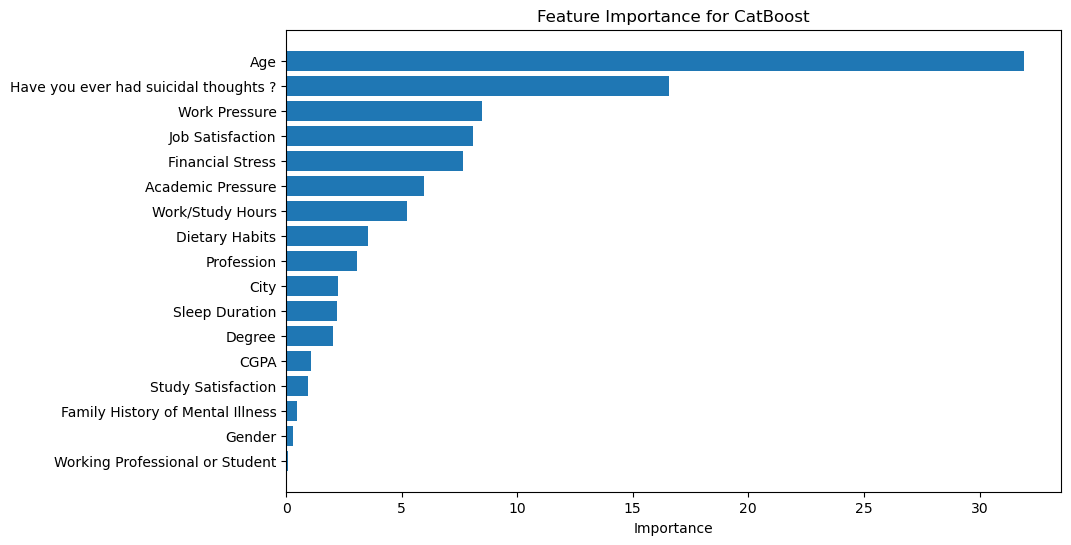

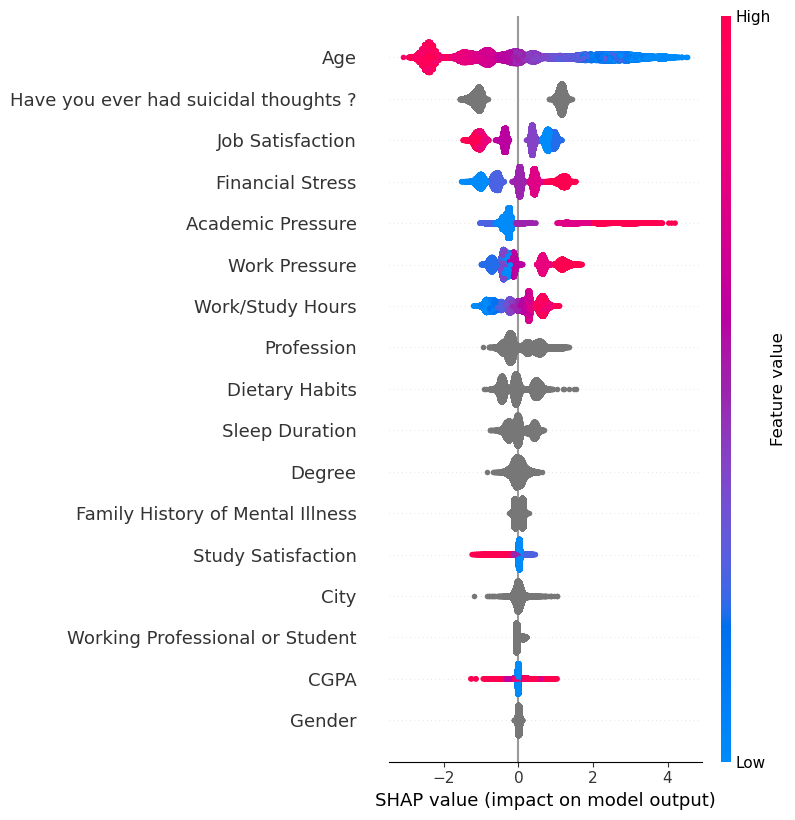

In [159]:
#Feature Importance
# Get feature importance values
feature_importances = catboost.get_feature_importance(train_pool)

# Combine names and importances and sort by importance descending
sorted_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

# Print sorted feature importances
for name, importance in sorted_features:
    print(f'{name}: {importance:.2f}')

# Unzip into two lists for plotting
sorted_names, sorted_importances = zip(*sorted_features)


# Plot sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importance for CatBoost')
plt.gca().invert_yaxis()
plt.show()


 # Calculate SHAP values 
# different graph, shows both feature importance and whether the value has to be lower or higher to be more likely for depression
shap_values = catboost.get_feature_importance(type='ShapValues', data=train_pool)

# summarize the effects of all the features
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [98]:
### All ROC Curves on One Graph

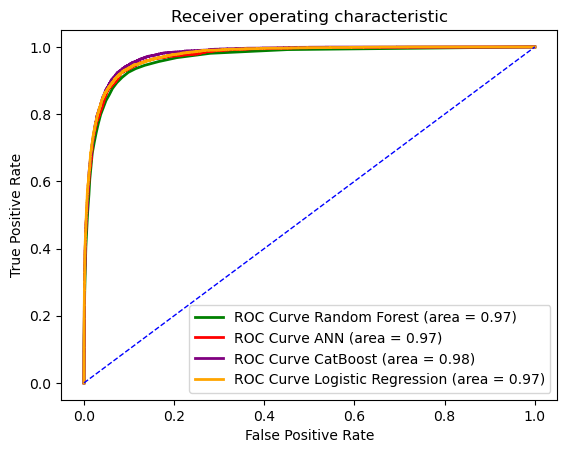

In [99]:
plt.plot(rf_fpr, rf_tpr, color='green', lw=2,
         label='ROC Curve Random Forest (area = %0.2f)' % rf_AUC)
plt.plot(ann_fpr, ann_tpr, color='red', lw=2,
         label='ROC Curve ANN (area = %0.2f)' % ann_AUC)
plt.plot(cb_fpr, cb_tpr, color='purple', lw=2,
         label='ROC Curve CatBoost (area = %0.2f)' % cb_AUC)
plt.plot(lr_fpr, lr_tpr, color='orange', lw=2,
         label='ROC Curve Logistic Regression (area = %0.2f)' % lr_AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

#Labeling the graph
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")